In [1]:
import sys
sys.path.append("../../")

from astronn.preprocess import prebedding
from astronn.datasets import bedding, starmodels, corot
from astronn import models

import tensorflow as tf
#tf.compat.v1.disable_v2_behavior() 

import pandas as pd
import numpy as np
import shap
import pickle 
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.mixture import GaussianMixture
from pygam import LogisticGAM, LinearGAM, s, te

from collections import Counter

Using TensorFlow backend.


#### Preprocess is not needed if data exists in beforehand

In [2]:
# Preprocess bedding stars (only once)
if False:
    preprocessor = prebedding(conf_file="../../astronn/data/bedding/parameters.csv", cols=["tess", "dnu"])
    preprocessor.preprocess_files(
        input_folder="../data/bedding/raw/*",
        output_folder="../data/bedding/preprocessed/",
    )

#### Load bedding stars data

In [3]:
bedding_stars = bedding()
df_bedding = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=57)

##### Take and show one example

b'tess2018349182459-s0006-0000000117766204-0126-s_lc_det'
75.69444400292855
b'tess2018319095959-s0005-0000000024344701-0125-s_lc_det'
85.64814925193787
b'tess2018319095959-s0005-0000000459942890-0125-s_lc_det'
82.87036860430682
b'tess2018319095959-s0005-0000000000589826-0125-s_lc_det'
75.46296274220502
b'tess2018319095959-s0005-0000000024344701-0125-s_lc_det'
85.64814925193787
b'tess2018319095959-s0005-0000000000589826-0125-s_lc_det'
75.46296274220502
b'tess2018263035959-s0003-0000000043363194-0123-s_lc_det'
79.74536882506476
b'tess2018319095959-s0005-0000000000589826-0125-s_lc_det'
75.46296274220502
b'tess2018263035959-s0003-0000000159895674-0123-s_lc_det'
79.39814969345375
b'tess2018319095959-s0005-0000000044645679-0125-s_lc_det'
72.10648170223942
b'tess2018349182459-s0006-0000000037498433-0126-s_lc_det'
82.17592482213621
b'tess2018349182459-s0006-0000000011199304-0126-s_lc_det'
68.98148192299736
b'tess2018292075959-s0004-0000000274038922-0124-s_lc_det'
83.33333112575389
b'tess201831

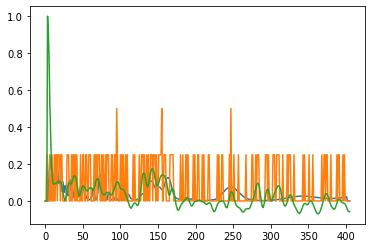

In [4]:
aux = None
for star in df_bedding.take(15):  # take the 1 bedding stars
    aux = star
    print(str(star[0].numpy()[0]))
    print(str(star[3].numpy()[0] / 0.0864)) # Show dnu in muHz from Bedding's paper
x = aux[1].numpy()

plt.plot(x[0, :, 0])
plt.plot(x[0, :, 1])
plt.plot(x[0, :, 2])
plt.show()

#### Utils functions

In [5]:
def normalize(x):
    """
    """
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Custom metrics
def top_2_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_4_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=4)

def top_6_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=6)

def top_8_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=8)

def calculate_shap_by_gradient(model, x_explain):
    """
    """
    e = shap.GradientExplainer(model, x_train, batch_size=1000, local_smoothing=0)
    shap_values, indexes = e.shap_values(x_explain, nsamples=10000, ranked_outputs=5)
    return shap_values, indexes

## Bedding 57 stars process

#### Read star models for Shap computation and load saved NN model

In [6]:
# Read datasets of preprocessed stars
bedding_stars = bedding()
df = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=1)
# Read star models (trainning) to calculate shap values
star_models = starmodels()
df_sm = star_models.load("/home/roberto/Downloads/dataall_parts/*", batch_size=150, add_noise=True)
_train_shap = np.asarray([line[0].numpy() for line in df_sm.take(10)])
_train_shap = _train_shap.reshape(
    (
        _train_shap.shape[0] * _train_shap.shape[1],
        _train_shap.shape[2],
        _train_shap.shape[3],
    )
)
number_shap_plots = 1

# Load model
sepconv_mod = tf.keras.models.load_model("/home/roberto/Projects/sepconvnn_tmp_400/")
sepconv_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 397, 10)           610       
_________________________________________________________________
batch_normalization (BatchNo (None, 397, 10)           40        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 198, 10)           0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 194, 10)           1510      
_________________________________________________________________
batch_normalization_1 (Batch (None, 194, 10)           40        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 97, 10)            0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 47, 10)            1

### NN inference on  bedding stars

In [7]:

# Shap explainer
e = shap.GradientExplainer(sepconv_mod, _train_shap, batch_size=10, local_smoothing=0)
# DS to save results
results = {}
# Loop over stars under study
count = 0
for star in df.take(57):  # take the 57 bedding stars
    if True:
        # Star channels info
        x_star = star[1].numpy()

        # Dnu NN inference
        dnu_hat = sepconv_mod.predict_classes(star[1])

        # Plot graphs and info (debug)
        if True:
            # Calculate gradient explainers and shap values
            shap_values, indexes = e.shap_values(
                star[1].numpy(), nsamples=100, ranked_outputs=40
            )

            # Log info
            print("Count: ", count)
            print("Star ID:", star[0].numpy()[0].decode("utf-8"))
            print("Shap values (sorted):", indexes)

            # Get top-k components
            #gmm = GaussianMixture(n_components=3).fit(indexes[0].reshape(-1, 1))
            #labels = gmm.predict(indexes[0].reshape(-1, 1))

            #def sort_dict(x):
            #    return {
            #        k: v
            #        for k, v in sorted(
            #            x.items(), key=lambda item: item[1], reverse=True
            #        )
            #    }

            #print("Top-k components")
            #topk_components = sort_dict(
            #    dict(zip([e[0] for e in gmm.means_], [e for e in gmm.weights_]))
            #)
            #print(topk_components)

            # Save results
            if star[0].numpy()[0].decode("utf-8") not in results:
                results[star[0].numpy()[0].decode("utf-8")] = {}
            results[star[0].numpy()[0].decode("utf-8")]["top-1"] = sepconv_mod.predict_classes(star[1])[0]
            #results[star[0].numpy()[0].decode("utf-8")]["top-k1"] = list(topk_components)[0]
            #results[star[0].numpy()[0].decode("utf-8")]["top-k2"] = list(topk_components)[1]
            #results[star[0].numpy()[0].decode("utf-8")]["top-k3"] = list(topk_components)[2]
            results[star[0].numpy()[0].decode("utf-8")]["dnu"] = star[3].numpy()[0] / 0.0864
            results[star[0].numpy()[0].decode("utf-8")]["prob"] =  sepconv_mod.predict_proba(star[1])[0][sepconv_mod.predict_classes(star[1])[0]]

            probs = sepconv_mod.predict_proba(star[1])[0]
            peaks, _ = find_peaks(probs, height=0, distance=10)
            #plt.plot(probs)
            #plt.plot(peaks, probs[peaks], "x")
            #plt.plot(np.zeros_like(probs), "--", color="gray")
            #plt.show()
            peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
            # we skip the 0 beacuse is the first one
            #results[star[0].numpy()[0].decode("utf-8")]["top-k1"] = np.where(probs==peaks_sorted_by_prob[0])[0][0]
            results[star[0].numpy()[0].decode("utf-8")]["top-k1"] = np.where(probs==peaks_sorted_by_prob[1])[0][0]
            results[star[0].numpy()[0].decode("utf-8")]["top-k2"] = np.where(probs==peaks_sorted_by_prob[2])[0][0]
            results[star[0].numpy()[0].decode("utf-8")]["top-k3"] = np.where(probs==peaks_sorted_by_prob[3])[0][0]
            results[star[0].numpy()[0].decode("utf-8")]["prob-topk1"] =  probs[np.where(probs==peaks_sorted_by_prob[1])[0][0]]
            results[star[0].numpy()[0].decode("utf-8")]["prob-topk2"] =  probs[np.where(probs==peaks_sorted_by_prob[2])[0][0]]
            results[star[0].numpy()[0].decode("utf-8")]["prob-topk3"] =  probs[np.where(probs==peaks_sorted_by_prob[3])[0][0]]


            print(results[star[0].numpy()[0].decode("utf-8")])


            # Plot star
            if False:
                x = np.arange(-1, 100.5, 0.25)  # x axis from 0 to 100
                plt.plot(x, x_star[0, :, 0])
                plt.plot(x, x_star[0, :, 1])
                plt.plot(x, x_star[0, :, 2])
                plt.show()
                plt.plot(sepconv_mod.predict_proba(x_star)[0][0:100])
                plt.show()

                # Plot shap
                
                plt.plot(
                    x,
                    shap_values[0][0][:, [0]],
                    label="dft",
                    linestyle="solid",
                    color="blue",
                )
                plt.plot(
                    x,
                    shap_values[0][0][:, [1]],
                    label="hd",
                    linestyle="solid",
                    color="orange",
                )
                plt.plot(
                    x,
                    shap_values[0][0][:, [2]],
                    label="ac",
                    linestyle="solid",
                    color="green",
                )

                plt.legend(title="Channels")
                plt.show()
                
                print("\n")

    count += 1


308926, 'prob-topk2': 0.01078284, 'prob-topk3': 0.007988144}
Count:  8
Star ID: tess2018349182459-s0006-0000000117766204-0126-s_lc_det
Shap values (sorted): [[76 74 75 38 37 39 77 78 36 73 79 35 40 34 80 81 82 33 41 72 62 22 63 23
  32 43 42 24 83 64 19 71 61 21  0 44 31 20 55 50]]
{'top-1': 76, 'dnu': 75.69444400292855, 'prob': 0.34656033, 'top-k1': 38, 'top-k2': 62, 'top-k3': 22, 'prob-topk1': 0.0814815, 'prob-topk2': 4.4342567e-05, 'prob-topk3': 3.624699e-05}
Count:  9
Star ID: tess2019032160000-s0008-0000000332516661-0136-s_lc_det
Shap values (sorted): [[55 53 54 58 56 57 70 69 52 35 34 59 74 36 75 60 37 71 33 73 38 51 50 66
  72 76 67 68 65 77 49 61 39 78 32 45 48 40 64 44]]
{'top-1': 55, 'dnu': 68.28703814082675, 'prob': 0.2356488, 'top-k1': 70, 'top-k2': 35, 'top-k3': 45, 'prob-topk1': 0.03479468, 'prob-topk2': 0.021379262, 'prob-topk3': 0.0018475623}
Count:  10
Star ID: tess2018234235059-s0002-0000000316806320-0121-s_lc_det
Shap values (sorted): [[29 27 28 30 26 31 25 22 32 23 

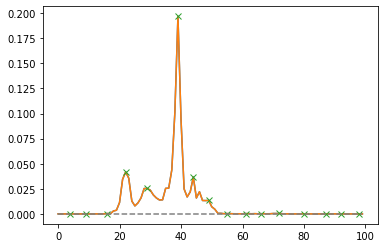

(array([22]),)

In [8]:
probs = sepconv_mod.predict_proba(star[1])[0]
plt.plot(probs)

peaks, _ = find_peaks(probs, height=0, distance=5)

plt.plot(probs)
plt.plot(peaks, probs[peaks], "x")
plt.plot(np.zeros_like(probs), "--", color="gray")
plt.show()

peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
np.where(probs==peaks_sorted_by_prob[1])


### Histogram of results for all stars (top-1)

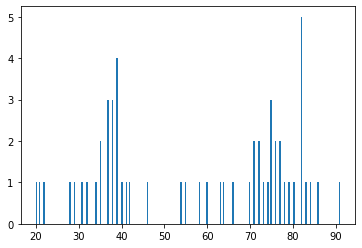

In [9]:
plt.hist([results[r]["top-1"] for r in results], bins=200)
plt.show()

In [10]:
df = pd.DataFrame.from_dict(results, orient="index")
df

top-1        dnu  \
tess2018263035959-s0003-0000000122686610-0123-s...     74  74.189813   
tess2019169103026-s0013-0000000269792989-0146-s...     82  78.009257   
tess2019058134432-s0009-0000000260161111-0139-s...     42  84.143518   
tess2018319095959-s0005-0000000100531058-0125-s...     39  79.861112   
tess2018319095959-s0005-0000000259675399-0125-s...     31  74.189813   
tess2019006130736-s0007-0000000078492107-0131-s...     37  79.282406   
tess2018319095959-s0005-0000000242944780-0125-s...     40  83.333331   
tess2018349182459-s0006-0000000032763133-0126-s...     46  85.069443   
tess2018349182459-s0006-0000000117766204-0126-s...     76  75.694444   
tess2019032160000-s0008-0000000332516661-0136-s...     55  68.287038   
tess2018234235059-s0002-0000000316806320-0121-s...     29  65.162038   
tess2018319095959-s0005-0000000255548143-0125-s...     38  79.861112   
tess2018292075959-s0004-0000000274038922-0124-s...     80  83.333331   
tess2019058134432-s0009-0000000388351327-0139-s...     71  82.870369   
tess2018263035959-s0003-0000000150272131-0123-s...     82  83.912037   
tess2018319095959-s0005-0000000071134596-0125-s...     41  87.499999   
tess2019006130736-s0007-0000000112484997-0131-s...     71  76.967594   
tess2018234235059-s0002-0000000281499618-0121-s...     21  82.986112   
tess2018349182459-s0006-0000000148228220-0126-s...     82  83.912037   
tess2019032160000-s0008-0000000176400189-0136-s...     82  76.851850   
tess2018319095959-s0005-0000000349645354-0125-s...     60  61.805557   
tess2018319095959-s0005-0000000031475829-0125-s...     84  84.490743   
tess2018319095959-s0005-0000000000589826-0125-s...     37  75.462963   
tess2018319095959-s0005-0000000034197596-0125-s...     37  78.125000   
tess2018263035959-s0003-0000000122615966-0123-s...     63  68.287038   
tess2019058134432-s0009-0000000287347434-0139-s...     79  81.597224   
tess2018349182459-s0006-0000000037498433-0126-s...     28  82.175925   
tess2018349182459-s0006-0000000294157254-0126-s...     76  80.092593   
tess2018234235059-s0002-0000000327996759-0121-s...     91  69.907407   
tess2018319095959-s0005-0000000459942890-0125-s...     39  82.870369   
tess2019032160000-s0008-0000000340358522-0136-s...     70  82.754631   
tess2018349182459-s0006-0000000124429243-0126-s...     78  74.074075   
tess2018319095959-s0005-0000000044645679-0125-s...     39  72.106482   
tess2019006130736-s0007-0000000278179191-0131-s...     38  80.555556   
tess2018349182459-s0006-0000000172193026-0126-s...     73  74.652776   
tess2018319095959-s0005-0000000348792358-0125-s...     75  80.439813   
tess2018319095959-s0005-0000000431695696-0125-s...     83  84.027780   
tess2018319095959-s0005-0000000009147509-0125-s...     72  71.180557   
tess2018349182459-s0006-0000000282265535-0126-s...     77  80.439813   
tess2018349182459-s0006-0000000124381332-0126-s...     86  86.226850   
tess2019058134432-s0009-0000000463556278-0139-s...     38  81.250000   
tess2018319095959-s0005-0000000316920092-0125-s...     35  80.671294   
tess2018349182459-s0006-0000000408906554-0126-s...     77  82.870369   
tess2018263035959-s0003-0000000043363194-0123-s...     54  79.745369   
tess2019006130736-s0007-0000000284348793-0131-s...     75  81.944444   
tess2018319095959-s0005-0000000143381070-0125-s...     58  88.310187   
tess2018349182459-s0006-0000000011199304-0126-s...     32  68.981482   
tess2018234235059-s0002-0000000224284988-0121-s...     66  68.634257   
tess2018234235059-s0002-0000000229139161-0121-s...     35  78.703706   
tess2018319095959-s0005-0000000246902545-0125-s...     34  70.601851   
tess2018319095959-s0005-0000000024344701-0125-s...     20  85.648149   
tess2018349182459-s0006-0000000034737955-0126-s...     64  69.791669   
tess2018263035959-s0003-0000000159895674-0123-s...     75  79.398150   
tess2018263035959-s0003-0000000231014033-0123-s...     22  84.490743   
tess2018319095959-s0005-0000000306773428-0125-s...     72  81.481481   
tess2018349182459-s0

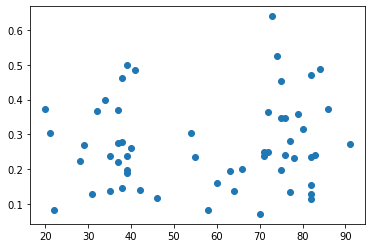

In [11]:
plt.scatter(df["top-1"], df["prob"])

In [12]:
inferences = [results[r]["top-1"] for r in results]
targets = [results[r]["dnu"] for r in results]
ids = results.keys()

Text(0, 0.5, 'NN Inference ($\\mu$Hz)')

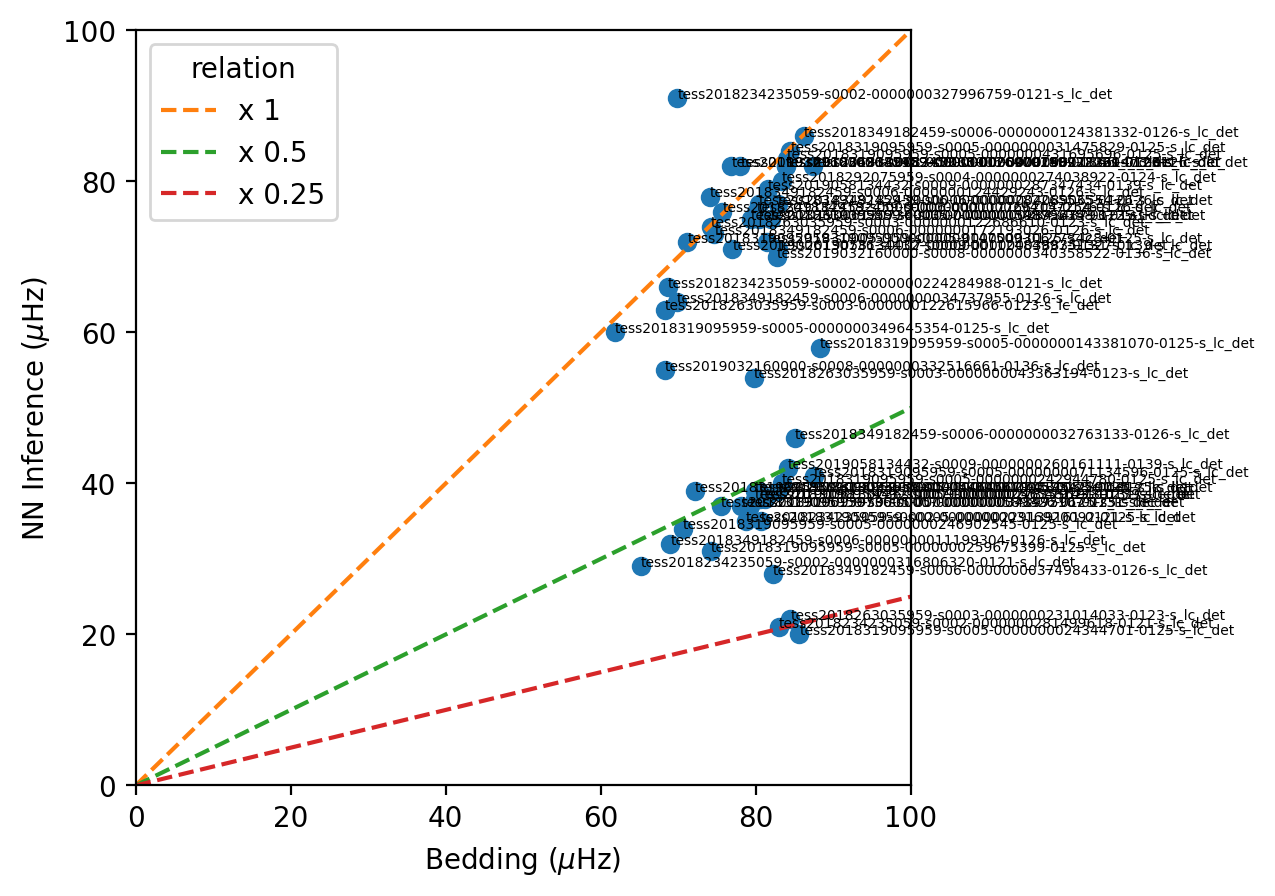

In [13]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', label="x "+str(slope))
    
# Set lims
plt.subplots(1, figsize=(5, 5), dpi=200)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.plot(targets, inferences, "o") # Plot relation
for i, txt in enumerate(ids):
    plt.annotate(txt, (targets[i], inferences[i]), size=5)

# Add multiple and submultiples
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
plt.legend(title="relation")
plt.xlabel("Bedding ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")

In [14]:
df.to_csv("/tmp/bedding_nn.csv.gz", index=True)

In [15]:
import numpy as np
len([e for e in np.unique([ee.split("-")[2] for ee in pd.read_csv('/tmp/bedding_nn.csv.gz', compression='gzip', header=0)["Unnamed: 0"]])])

57

In [16]:
np.unique([e.split("-")[0] for e in df.index])
len(df)
df

top-1        dnu  \
tess2018263035959-s0003-0000000122686610-0123-s...     74  74.189813   
tess2019169103026-s0013-0000000269792989-0146-s...     82  78.009257   
tess2019058134432-s0009-0000000260161111-0139-s...     42  84.143518   
tess2018319095959-s0005-0000000100531058-0125-s...     39  79.861112   
tess2018319095959-s0005-0000000259675399-0125-s...     31  74.189813   
tess2019006130736-s0007-0000000078492107-0131-s...     37  79.282406   
tess2018319095959-s0005-0000000242944780-0125-s...     40  83.333331   
tess2018349182459-s0006-0000000032763133-0126-s...     46  85.069443   
tess2018349182459-s0006-0000000117766204-0126-s...     76  75.694444   
tess2019032160000-s0008-0000000332516661-0136-s...     55  68.287038   
tess2018234235059-s0002-0000000316806320-0121-s...     29  65.162038   
tess2018319095959-s0005-0000000255548143-0125-s...     38  79.861112   
tess2018292075959-s0004-0000000274038922-0124-s...     80  83.333331   
tess2019058134432-s0009-0000000388351327-0139-s...     71  82.870369   
tess2018263035959-s0003-0000000150272131-0123-s...     82  83.912037   
tess2018319095959-s0005-0000000071134596-0125-s...     41  87.499999   
tess2019006130736-s0007-0000000112484997-0131-s...     71  76.967594   
tess2018234235059-s0002-0000000281499618-0121-s...     21  82.986112   
tess2018349182459-s0006-0000000148228220-0126-s...     82  83.912037   
tess2019032160000-s0008-0000000176400189-0136-s...     82  76.851850   
tess2018319095959-s0005-0000000349645354-0125-s...     60  61.805557   
tess2018319095959-s0005-0000000031475829-0125-s...     84  84.490743   
tess2018319095959-s0005-0000000000589826-0125-s...     37  75.462963   
tess2018319095959-s0005-0000000034197596-0125-s...     37  78.125000   
tess2018263035959-s0003-0000000122615966-0123-s...     63  68.287038   
tess2019058134432-s0009-0000000287347434-0139-s...     79  81.597224   
tess2018349182459-s0006-0000000037498433-0126-s...     28  82.175925   
tess2018349182459-s0006-0000000294157254-0126-s...     76  80.092593   
tess2018234235059-s0002-0000000327996759-0121-s...     91  69.907407   
tess2018319095959-s0005-0000000459942890-0125-s...     39  82.870369   
tess2019032160000-s0008-0000000340358522-0136-s...     70  82.754631   
tess2018349182459-s0006-0000000124429243-0126-s...     78  74.074075   
tess2018319095959-s0005-0000000044645679-0125-s...     39  72.106482   
tess2019006130736-s0007-0000000278179191-0131-s...     38  80.555556   
tess2018349182459-s0006-0000000172193026-0126-s...     73  74.652776   
tess2018319095959-s0005-0000000348792358-0125-s...     75  80.439813   
tess2018319095959-s0005-0000000431695696-0125-s...     83  84.027780   
tess2018319095959-s0005-0000000009147509-0125-s...     72  71.180557   
tess2018349182459-s0006-0000000282265535-0126-s...     77  80.439813   
tess2018349182459-s0006-0000000124381332-0126-s...     86  86.226850   
tess2019058134432-s0009-0000000463556278-0139-s...     38  81.250000   
tess2018319095959-s0005-0000000316920092-0125-s...     35  80.671294   
tess2018349182459-s0006-0000000408906554-0126-s...     77  82.870369   
tess2018263035959-s0003-0000000043363194-0123-s...     54  79.745369   
tess2019006130736-s0007-0000000284348793-0131-s...     75  81.944444   
tess2018319095959-s0005-0000000143381070-0125-s...     58  88.310187   
tess2018349182459-s0006-0000000011199304-0126-s...     32  68.981482   
tess2018234235059-s0002-0000000224284988-0121-s...     66  68.634257   
tess2018234235059-s0002-0000000229139161-0121-s...     35  78.703706   
tess2018319095959-s0005-0000000246902545-0125-s...     34  70.601851   
tess2018319095959-s0005-0000000024344701-0125-s...     20  85.648149   
tess2018349182459-s0006-0000000034737955-0126-s...     64  69.791669   
tess2018263035959-s0003-0000000159895674-0123-s...     75  79.398150   
tess2018263035959-s0003-0000000231014033-0123-s...     22  84.490743   
tess2018319095959-s0005-0000000306773428-0125-s...     72  81.481481   
tess2018349182459-s0

In [17]:
df["TIC"] = (
    df.index.str.split("-", n=2, expand=False)
    .str[2]
    .str.split("-")
    .str[0]
    .astype(int)
    .astype(str)
)
df_att = pd.io.parsers.read_csv("../data/bedding/bedding.csv", sep=",", index_col=0)
df_joined = df.set_index("TIC").join(df_att.set_index("TIC"))
# Add flag
df_joined["abs_error"] = np.abs(df_joined["top-1"] - df_joined["dnu"])
df_joined["flag"] = df_joined["abs_error"] < 12
pd.set_option("display.max_columns", None)
df_joined

top-1        dnu      prob  top-k1  top-k2  top-k3  prob-topk1  \
TIC                                                                         
122686610     74  74.189813  0.526657      94      58      12    0.000601   
269792989     82  78.009257  0.233661      18      97      58    0.021134   
260161111     42  84.143518  0.139963      84      32      65    0.092620   
100531058     39  79.861112  0.499816      82      22      62    0.001430   
259675399     31  74.189813  0.126752      42      19      60    0.030677   
78492107      37  79.282406  0.371341      23      74      55    0.001911   
242944780     40  83.333331  0.260870      82      23      52    0.087674   
32763133      46  85.069443  0.115405      88      35      70    0.030893   
117766204     76  75.694444  0.346560      38      62      22    0.081482   
332516661     55  68.287038  0.235649      70      35      45    0.034795   
316806320     29  65.162038  0.270106      39      57      13    0.002457   
255548143     38  79.861112  0.146148      69      53      80    0.072075   
274038922     80  83.333331  0.315908      64      39      19    0.007572   
388351327     71  82.870369  0.248017      39      51      61    0.023921   
150272131     82  83.912037  0.470266      41      57      23    0.022094   
71134596      41  87.499999  0.485906      87      23      70    0.023552   
112484997     71  76.967594  0.238883      34      50      22    0.056450   
281499618     21  82.986112  0.304529      34      51      79    0.012736   
148228220     82  83.912037  0.154898      71      57      47    0.085190   
176400189     82  76.851850  0.126826      71      95      50    0.059650   
349645354     60  61.805557  0.159538      34      46      22    0.068536   
31475829      84  84.490743  0.488649      41      65      53    0.001071   
589826        37  75.462963  0.273800      23      73      12    0.013189   
34197596      37  78.125000  0.219918      80      62      22    0.023649   
122615966     63  68.287038  0.193372      31      44      73    0.058921   
287347434     79  81.597224  0.358862      39      62      52    0.000342   
37498433      28  82.175925  0.223746      40      16      61    0.097306   
294157254     76  80.092593  0.240811      38      53      66    0.019152   
327996759     91  69.907407  0.271181      44      72      56    0.049143   
459942890     39  82.870369  0.237194      80      55      23    0.084951   
340358522     70  82.754631  0.070641      38      57      84    0.069475   
124429243     78  74.074075  0.231704      38      55      22    0.033815   
44645679      39  72.106482  0.189241      62      22       4    0.002968   
278179191     38  80.555556  0.278376      79      50      27    0.020479   
172193026     73  74.652776  0.640161      35      63      53    0.002906   
348792358     75  80.439813  0.198064      63      34      96    0.109896   
431695696     83  84.027780  0.240737      41      69      57    0.235500   
9147509       72  71.180557  0.363941      35      12      88    0.022614   
282265535     77  80.439813  0.281301      39      52      62    0.001016   
124381332     86  86.226850  0.371598      42      70      57    0.007699   
463556278     38  81.250000  0.461308      80      23      55    0.002365   
316920092     35  80.671294  0.238940      70      47      57    0.010701   
408906554     77  82.870369  0.133039      38      49      22    0.128307   
43363194      54  79.745369  0.303580      35      78      66    0.056046   
284348793     75  81.944444  0.452991      60      37      90    0.000644   
143381070     58  88.310187  0.081303      88      45      71    0.063309   
11199304      32  68.981482  0.365773      67      55      43    0.089287   
224284988     66  68.634257  0.200500      32      51      20    0.099267   
229139161     35  78.703706  0.137835      46      20      66    0.012415   
246902545     34  70.601851  0.398031      22      69      46    0.007561   
2434470

### Multilevel analisis

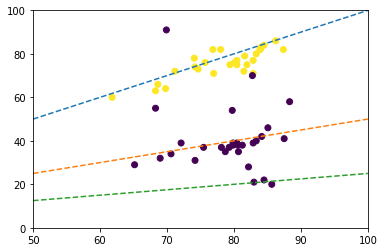

In [18]:
#df_joined = df_joined.drop("143381070")
#df_joined = df_joined.drop("332516661")
#df_joined = df_joined.drop("327996759")
#df_joined = df_joined.drop("43363194")
plt.scatter(df_joined["dnu"] , df_joined["top-1"], c=df_joined["flag"])
plt.xlim(50, 100)
plt.ylim(0, 100)
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       8.132
Link Function:                        LogitLink Log Likelihood:                                   -28.8776
Number of Samples:                           46 AIC:                                               74.0193
                                                AICc:                                              79.1785
                                                UBRE:                                               3.7505
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0943
Feature Function                  Lam

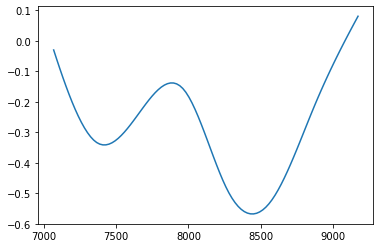

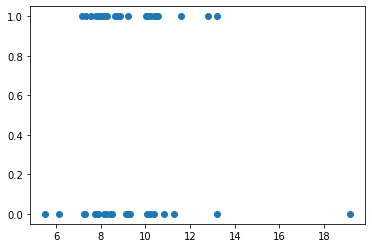

In [19]:
_x = df_joined[
    df_joined["L"].notna() & df_joined["Teff"].notna() & df_joined["V"].notna()
]
gam = LogisticGAM(s(0) + s(1) + s(2), n_splines=10)
gam.fit(_x[["L", "Teff", "V"]], _x["flag"])
gam.summary()

XX = gam.generate_X_grid(term=1)
plt.plot(XX[:, 1], gam.partial_dependence(term=1, X=XX))
plt.show()
plt.scatter(_x["L"], _x["flag"])

_x.to_csv("/home/roberto/bedding_joined.csv", index=True)

## Join Star models with ${\Delta\nu}_{bedding}$ and ${T_{eff}}_{bedding}$  

In [20]:
df_dnus = pd.read_csv("/tmp/files_dnus.csv",sep=",",header=0,  names=["file", "dnu"])
df_dnus.head()

file    dnu
0  VO-m275fe0a164o0rotjpzt5p7-ad/00158-m275fe0a16...  5.118
1  VO-m260fe-3a164o0rotjpzt5p7-ad/00221-m260fe-3a...  4.787
2  VO-m275fe0a164o0rotjpzt5p7-ad/00415-m275fe0a16...  3.416
3  VO-m145fe-3a164o0rotjpzt5p5-ad/00960-m145fe-3a...  5.022
4  VO-m135fe010a164o00rotjpzt5p7-ad/00292-m135fe0...  7.687

In [21]:
with open(
    "/home/roberto/Projects/asteroseismologyNN/selected_models_preprocessed.csv", "w"
) as outfile:
    wr = csv.writer(outfile)
    wr.writerow(["xc", "l", "teff", "selected", "path"])
    with open(
        "/home/roberto/Projects/asteroseismologyNN/selected_models.csv", "r"
    ) as infile:
        for id, row in enumerate(infile):
            if id > 0:
                chunks = row.split(",")
                if len(chunks) == 8:
                    try:
                        aux = [
                            float(chunks[0] + "." + chunks[1]),
                            float(chunks[2] + "." + chunks[3]),
                            float(chunks[4] + "." + chunks[5]),
                            chunks[6],
                            chunks[7].replace('"', "").replace("\n", ""),
                        ]
                        wr.writerow(aux)
                    except:
                        aux = [
                            float(0.0),
                            float(0.0),
                            float(chunks[4] + "." + chunks[5]),
                            chunks[6],
                            chunks[7].replace('"', "").replace("\n", ""),
                        ]
                        wr.writerow(aux)

In [22]:
df_l_teff = pd.read_csv(
    "/home/roberto/Projects/asteroseismologyNN/selected_models_preprocessed.csv",
    sep=",",
    header=0,
    names=["xc", "l", "teff", "selected", "path"],
)
df_l_teff.head()
print(len(df_l_teff))

506784


In [23]:
df_dnu_l_teff = df_dnus.set_index("file").join(df_l_teff.set_index("path"))
df_dnu_l_teff["dnu"] = df_dnu_l_teff["dnu"] / 0.0864
df_dnu_l_teff.head()

dnu        xc  \
file                                                                      
VO-m275fe0a164o0rotjpzt5p7-ad/00158-m275fe0a164...  59.236111  0.622402   
VO-m260fe-3a164o0rotjpzt5p7-ad/00221-m260fe-3a1...  55.405093  0.631469   
VO-m275fe0a164o0rotjpzt5p7-ad/00415-m275fe0a164...  39.537037  0.372260   
VO-m145fe-3a164o0rotjpzt5p5-ad/00960-m145fe-3a1...  58.125000  0.138201   
VO-m135fe010a164o00rotjpzt5p7-ad/00292-m135fe01...  88.969907  0.514600   

                                                            l          teff  \
file                                                                          
VO-m275fe0a164o0rotjpzt5p7-ad/00158-m275fe0a164...  52.276290  10643.345609   
VO-m260fe-3a164o0rotjpzt5p7-ad/00221-m260fe-3a1...  36.650261   9763.029945   
VO-m275fe0a164o0rotjpzt5p7-ad/00415-m275fe0a164...  63.041466   9777.683034   
VO-m145fe-3a164o0rotjpzt5p5-ad/00960-m145fe-3a1...   4.259204   5961.591979   
VO-m135fe010a164o00rotjpzt5p7-ad/00292-m135fe01...   3.247009   6456.429298   

                                                   selected  
file                                                         
VO-m275fe0a164o0rotjpzt5p7-ad/00158-m275fe0a164...     True  
VO-m260fe-3a164o0rotjpzt5p7-ad/00221-m260fe-3a1...     True  
VO-m275fe0a164o0rotjpzt5p7-ad/00415-m275fe0a164...     True  
VO-m145fe-3a164o0rotjpzt5p5-ad/00960-m145fe-3a1...     True  
VO-m135fe010a164o00rotjpzt5p7-ad/00292-m135fe01...     True

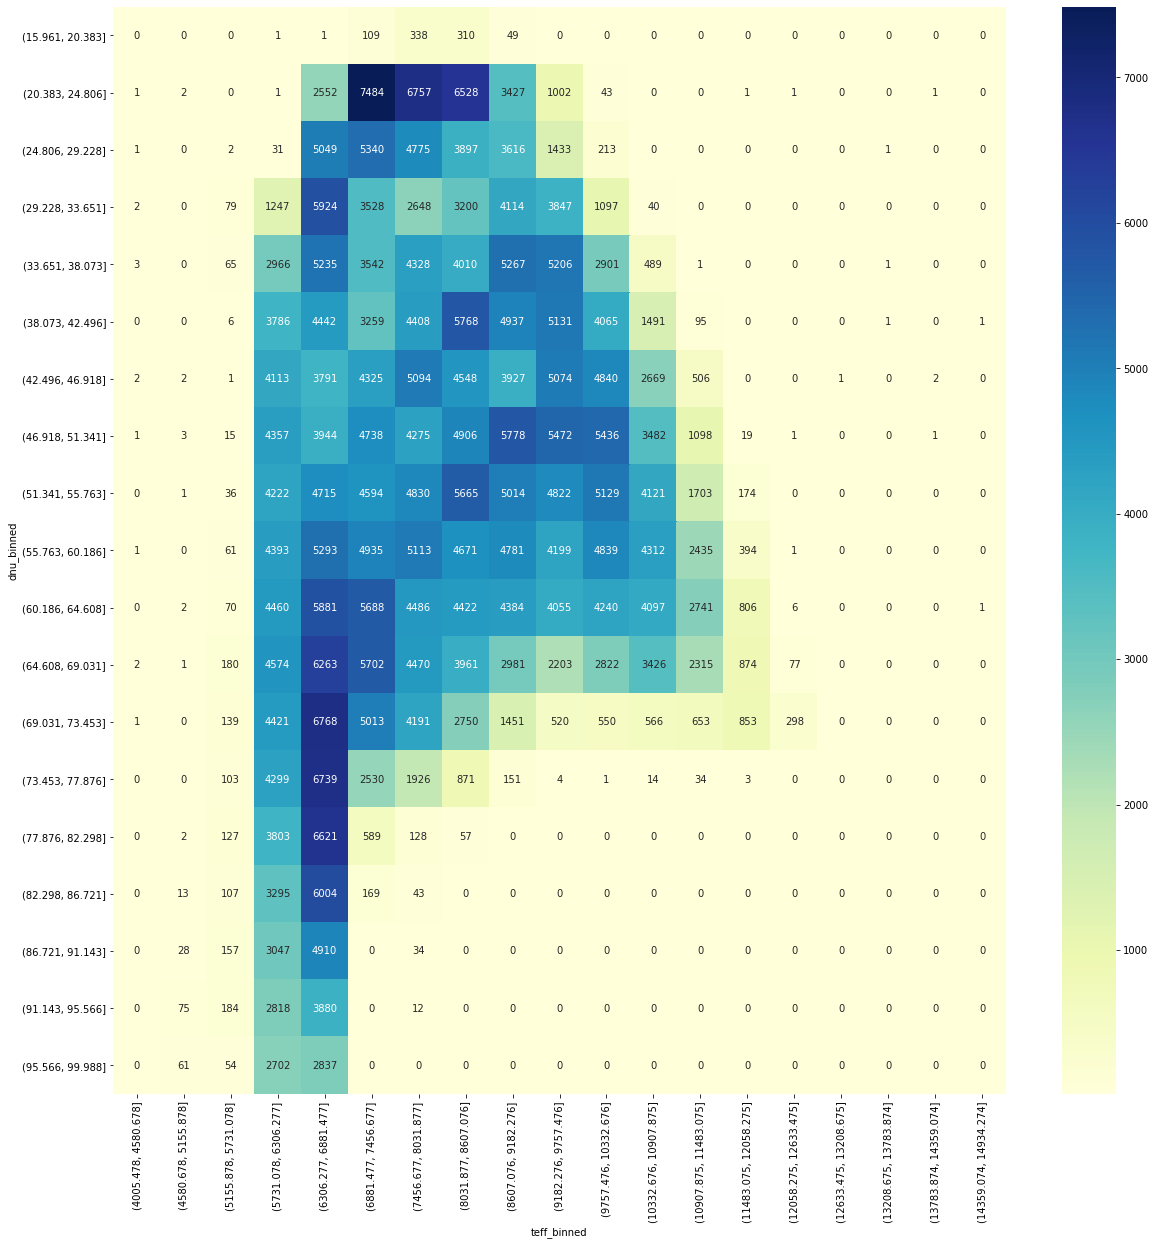

In [24]:
df_dnu_l_teff_filter = df_dnu_l_teff[
    (df_dnu_l_teff["dnu"] < 100) & (df_dnu_l_teff["dnu"] > 1)
]

df_dnu_l_teff_filter["dnu_binned"] = pd.cut(
    df_dnu_l_teff_filter["dnu"],
    np.linspace(
        df_dnu_l_teff_filter["dnu"].min(), df_dnu_l_teff_filter["dnu"].max(), 20
    ),
)
df_dnu_l_teff_filter["teff_binned"] = pd.cut(
    df_dnu_l_teff_filter["teff"],
    np.linspace(
        df_dnu_l_teff_filter["teff"].min(), df_dnu_l_teff_filter["teff"].max(), 20
    ),
)

df_grouped = (
    df_dnu_l_teff_filter.groupby(["dnu_binned", "teff_binned"]).size().unstack()
)
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(df_grouped, linewidth=0.0, annot=True, cmap="YlGnBu", fmt="d", vmin=10)
plt.show()

## Inclination angle

In [25]:

results = []
for index in range(len(df_joined)):
    flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index]["top-1"] - 1.0) & (
        df_dnu_l_teff["dnu"] <= df_joined.iloc[index]["top-1"] + 1.0
    )
    flag_teff = (
        df_dnu_l_teff["teff"]
        >= df_joined.iloc[index]["Teff"] - df_joined.iloc[index]["Teff"] * 0.01
    ) & (
        df_dnu_l_teff["teff"]
        <= df_joined.iloc[index]["Teff"] + df_joined.iloc[index]["Teff"] * 0.01
    )
    selected = df_dnu_l_teff[flag_dnu & flag_teff]["l"]
    if np.isnan(selected.mean()):
        results.append(np.nan)
    else:
        results.append(df_joined.iloc[index]["L"] > selected.quantile(0.1))

df_joined["inc_angle"] = results
df_joined.head(30)[["top-1", "L", "dnu", "inc_angle"]]
print(df_joined[["Teff", "L", "top-1", "dnu", "inc_angle", "flag"]].head(50))


results = []
inferences = []
for index in range(len(df_joined)):
    subresult = []
    for inference in ["top-1", "top-k1", "top-k2", "top-k3"]:
        flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index][inference] - 1.0) & (
            df_dnu_l_teff["dnu"] <= df_joined.iloc[index][inference] + 1.0
        )
        flag_teff = (
            df_dnu_l_teff["teff"]
            >= df_joined.iloc[index]["Teff"] - df_joined.iloc[index]["Teff"] * 0.2
        ) & (
            df_dnu_l_teff["teff"]
            <= df_joined.iloc[index]["Teff"] + df_joined.iloc[index]["Teff"] * 0.2
        )
        selected = df_dnu_l_teff[flag_dnu & flag_teff]["l"]
        if len(selected) < 5:
            subresult.append(np.nan)
        else:
            subresult.append(round(abs(df_joined.iloc[index]["L"]-selected.quantile(0.5)), 2))
    
    subresult.append(df_joined.iloc[index]["L"])
    results.append(subresult)

             Teff      L  top-1        dnu inc_angle   flag
TIC                                                        
122686610  7880.0  10.21     74  74.189813      True   True
269792989     NaN    NaN     82  78.009257       NaN   True
260161111  8370.0   9.33     42  84.143518     False  False
100531058  8430.0  10.38     39  79.861112     False  False
259675399  7690.0   8.25     31  74.189813     False  False
78492107   7820.0   9.15     37  79.282406     False  False
242944780  7410.0   7.25     40  83.333331     False  False
32763133   8170.0  11.27     46  85.069443     False  False
117766204  8060.0  10.39     76  75.694444      True   True
332516661  7340.0   7.79     55  68.287038     False  False
316806320     NaN    NaN     29  65.162038       NaN  False
255548143  7660.0   7.82     38  79.861112     False  False
274038922  7970.0   8.06     80  83.333331       NaN   True
388351327     NaN    NaN     71  82.870369       NaN   True
150272131  7890.0   7.87     82  83.9120

In [26]:
#m = pd.DataFrame(np.asarray(results))
#m.index = df_joined.index
#m

In [27]:
def f(row):
    if np.isnan(row["inc_angle"]):
        val = 0
    else:
        val = 1
    return val
df_joined['drop'] = df_joined.apply(f, axis=1)

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.6986
Link Function:                     IdentityLink Log Likelihood:                                  -159.5785
Number of Samples:                           47 AIC:                                              328.5541
                                                AICc:                                             329.8507
                                                GCV:                                                0.1111
                                                Scale:                                              0.0955
                                                Pseudo R-Squared:                                   0.2102
Feature Function                  Lam

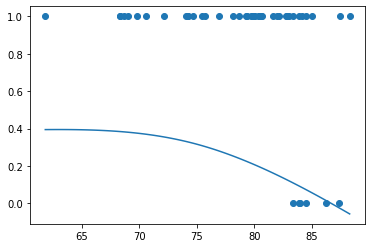

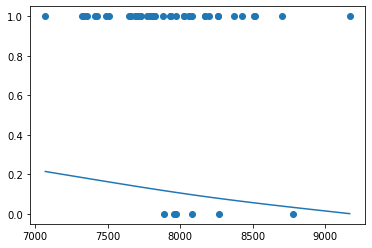

In [28]:
_x = df_joined[df_joined['Teff'].notna()]

gam = LinearGAM(s(0)+s(1), n_splines=5)
gam.fit(_x[["dnu","Teff"]], _x["drop"])
gam.summary()

XX = gam.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
plt.scatter(_x["dnu"], _x["drop"])
plt.show()

XX = gam.generate_X_grid(term=1)
plt.plot(XX[:, 1], gam.partial_dependence(term=1, X=XX))
plt.scatter(_x["Teff"], _x["drop"])

In [29]:
df_joined.groupby(["flag", "inc_angle"]).size().unstack(fill_value=0)

inc_angle  False  True 
flag                   
False         23      1
True           9      8

Text(0, 0.5, 'NN Inference ($\\mu$Hz)')

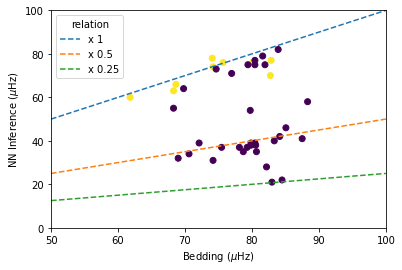

In [30]:
plt.scatter(df_joined["dnu"] , df_joined["top-1"], c=df_joined["inc_angle"])
plt.xlim(50, 100)
plt.ylim(0, 100)
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
plt.legend(title="relation")
plt.xlabel("Bedding ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                         2.0
Link Function:                        LogitLink Log Likelihood:                                   -21.8151
Number of Samples:                           40 AIC:                                               47.6303
                                                AICc:                                              48.2969
                                                UBRE:                                               3.2308
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2002
Feature Function                  Lam

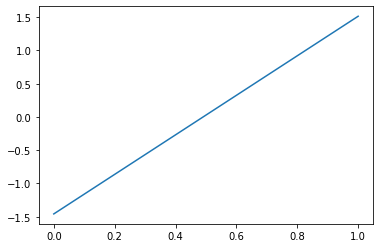

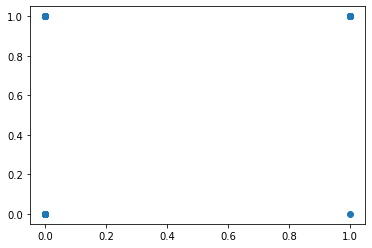

In [31]:
_x = df_joined[df_joined["inc_angle"].notna() & df_joined["L"].notna()]
gam = LogisticGAM(s(0))
gam.fit(_x[["inc_angle"]], _x["flag"])
gam.summary()

XX = gam.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
plt.show()
plt.scatter(_x["inc_angle"], _x["flag"])

_x.to_csv("/home/roberto/bedding_joined.csv", index=True)

## $T_{eff}$, L and $\Delta \nu$ star models match

In [32]:
results = []
for index in range(len(df_joined)):
    flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index]["top-1"] - 1.0) & (
        df_dnu_l_teff["dnu"] <= df_joined.iloc[index]["top-1"] + 1.0
    )
    flag_teff = (
        df_dnu_l_teff["teff"]
        >= df_joined.iloc[index]["Teff"] - df_joined.iloc[index]["Teff"] * 0.02
    ) & (
        df_dnu_l_teff["teff"]
        <= df_joined.iloc[index]["Teff"] + df_joined.iloc[index]["Teff"] * 0.02
    )
    flag_l = (df_dnu_l_teff["l"] >= df_joined.iloc[index]["L"] - 3.0) & (
        df_dnu_l_teff["l"] <= df_joined.iloc[index]["L"] + 3.0
    )
    selected = df_dnu_l_teff[flag_dnu & flag_teff & flag_l]
    if np.isnan(df_joined.iloc[index]["L"]):
        results.append(np.nan)
    else:
        results.append(len(selected) > 0)

df_joined["star_match"] = results
#print(
#    df_joined[["Teff", "L", "top-1", "dnu", "inc_angle", "flag", "star_match"]].head(50)
#)

star_match  False  True 
flag                    
False          21      2
True            6     17


Text(0, 0.5, 'NN Inference ($\\mu$Hz)')

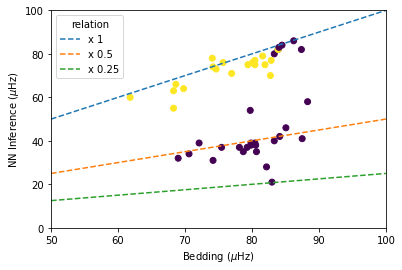

In [33]:
print(df_joined.groupby(["flag", "star_match"]).size().unstack(fill_value=0))

plt.scatter(df_joined["dnu"] , df_joined["top-1"], c=df_joined["star_match"])
plt.xlim(50, 100)
plt.ylim(0, 100)
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
plt.legend(title="relation")
plt.xlabel("Bedding ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")

## Get L from adjusted GAM model

In [34]:
df_grouped.head(30).stack()[:3]

dnu_binned        teff_binned         
(15.961, 20.383]  (4005.478, 4580.678]    0
                  (4580.678, 5155.878]    0
                  (5155.878, 5731.078]    0
dtype: int64

In [35]:
_x = df_dnu_l_teff_filter[df_dnu_l_teff_filter['l'].notna()]

gam_teff_dnu = LinearGAM(te(0,1, n_splines=15))
gam_teff_dnu.fit(_x[["dnu","teff"]], _x["l"])
gam_teff_dnu.summary()

# Save model
with open("../models/gam_teff_dnu/gam.pkl", 'wb') as f:
    pickle.dump(gam_teff_dnu, f)

#XX = gam.generate_X_grid(term=0)
#plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
#plt.scatter(_x["teff"], _x["l"])
#plt.show()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     84.6873
Link Function:                     IdentityLink Log Likelihood:                               -960654.4226
Number of Samples:                       494768 AIC:                                          1921480.2198
                                                AICc:                                         1921480.2499
                                                GCV:                                                2.2207
                                                Scale:                                                2.22
                                                Pseudo R-Squared:                                   0.9958
Feature Function                  Lam

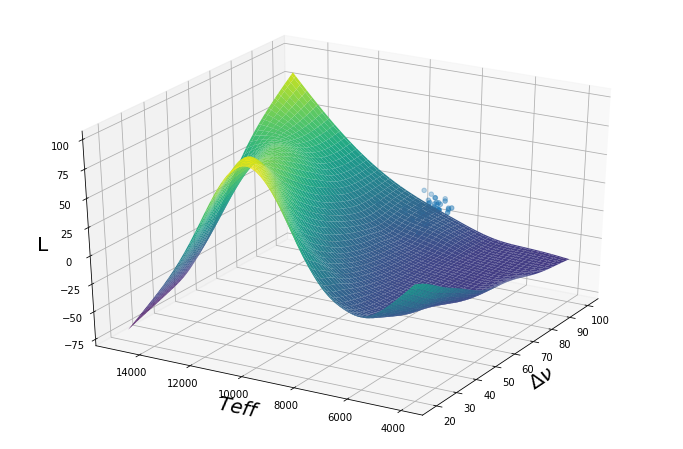

In [36]:
XX = gam_teff_dnu.generate_X_grid(term=0, meshgrid=True)
Z = gam_teff_dnu.partial_dependence(term=0, X=XX, meshgrid=True)

plt.ion()
plt.rcParams['figure.figsize'] = (12, 8)
ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
ax.set_xlabel('$\Delta\\nu$', fontsize=20)
ax.set_ylabel('$Teff$', fontsize=20)
ax.set_zlabel('L', fontsize=20)
ax.view_init(30, 210)

ax.scatter(df_joined["Dnu"]/0.0864, df_joined["Teff"], df_joined["L"], "red")
plt.show()

In [37]:
tops = []
for index in range(len(df_joined)):
    subtops = []
    subtops.append(df_joined.iloc[index]["top-1"])
    subtops.append(df_joined.iloc[index]["top-k1"])
    subtops.append(df_joined.iloc[index]["top-k2"])
    subtops.append(df_joined.iloc[index]["top-k3"])
    tops.append(subtops)
tops = pd.DataFrame(np.asarray(tops))
tops

0   1   2   3
0   74  94  58  12
1   82  18  97  58
2   42  84  32  65
3   39  82  22  62
4   31  42  19  60
5   37  23  74  55
6   40  82  23  52
7   46  88  35  70
8   76  38  62  22
9   55  70  35  45
10  29  39  57  13
11  38  69  53  80
12  80  64  39  19
13  71  39  51  61
14  82  41  57  23
15  41  87  23  70
16  71  34  50  22
17  21  34  51  79
18  82  71  57  47
19  82  71  95  50
20  60  34  46  22
21  84  41  65  53
22  37  23  73  12
23  37  80  62  22
24  63  31  44  73
25  79  39  62  52
26  28  40  16  61
27  76  38  53  66
28  91  44  72  56
29  39  80  55  23
30  70  38  57  84
31  78  38  55  22
32  39  62  22   4
33  38  79  50  27
34  73  35  63  53
35  75  63  34  96
36  83  41  69  57
37  72  35  12  88
38  77  39  52  62
39  86  42  70  57
40  38  80  23  55
41  35  70  47  57
42  77  38  49  22
43  54  35  78  66
44  75  60  37  90
45  58  88  45  71
46  32  67  55  43
47  66  32  51  20
48  35  46  20  66
49  34  22  69  46
50  20  32   9  46
51  64  88  43  12
52  75  62  97  37
53  22  32  53  85
54  72  82  36  55
55  82  70  41  57
56  39  22  49  72

In [38]:
corrected = []
uncertainty = []
for index in range(len(df_joined)):
    l = df_joined.iloc[index][["L"]][0]

    if not np.isnan(l):
        l_top1 = round(
            gam_teff_dnu.predict(
                df_joined.iloc[index][["top-1", "Teff"]].to_numpy().reshape(1, 2)
            )[0],
            2,
        )
        conf_top1 = gam_teff_dnu.prediction_intervals(df_joined.iloc[index][["top-1", "Teff"]].to_numpy().reshape(1, 2))
        in_conf_top1 = (l >= conf_top1[0][0]) & (l <= conf_top1[0][1])

        l_topk1 = round(
            gam_teff_dnu.predict(
                df_joined.iloc[index][["top-k1", "Teff"]].to_numpy().reshape(1, 2)
            )[0],
            2,
        )
        conf_topk1 = gam_teff_dnu.prediction_intervals(df_joined.iloc[index][["top-k1", "Teff"]].to_numpy().reshape(1, 2))
        in_conf_topk1 = (l >= conf_topk1[0][0]) & (l <= conf_topk1[0][1])

        l_topk2 = round(
            gam_teff_dnu.predict(
                df_joined.iloc[index][["top-k2", "Teff"]].to_numpy().reshape(1, 2)
            )[0],
            2,
        )
        conf_topk2 = gam_teff_dnu.prediction_intervals(df_joined.iloc[index][["top-k2", "Teff"]].to_numpy().reshape(1, 2))
        in_conf_topk2 = (l >= conf_topk2[0][0]) & (l <= conf_topk2[0][1])

        l_topk3 = round(
            gam_teff_dnu.predict(
                df_joined.iloc[index][["top-k3", "Teff"]].to_numpy().reshape(1, 2)
            )[0],
            2,
        )
        conf_topk3 = gam_teff_dnu.prediction_intervals(df_joined.iloc[index][["top-k3", "Teff"]].to_numpy().reshape(1, 2))
        in_conf_topk3 = (l >= conf_topk3[0][0]) & (l <= conf_topk3[0][1])

        errors = [
            round(np.power(l_top1 - l, 2), 2),
            round(np.power(l_topk1 - l, 2), 2),
            round(np.power(l_topk2 - l, 2), 2),
            round(np.power(l_topk3 - l, 2), 2),
        ]

        inds = np.asarray(errors).argsort()

        uncertainty.append(errors[inds[1]] - errors[inds[0]])
        i = np.argmin(errors)

        # print(errors)
        corrected.append(tops.iloc[index][errors.index(min(errors))])
    else:
        corrected.append(np.nan)
        uncertainty.append(np.nan)

In [39]:
"""
corrected = []
uncertainty = []
for index in range(len(df_joined)):
    l = df_joined.iloc[index][["L"]][0]

    if not np.isnan(l):
        flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index]["top-1"] - 1.0) & (
        df_dnu_l_teff["dnu"] <= df_joined.iloc[index]["top-1"] + 1.0
        )
        flag_teff = (
            df_dnu_l_teff["teff"]
            >= df_joined.iloc[index]["Teff"] - df_joined.iloc[index]["Teff"] * 0.02
        ) & (
            df_dnu_l_teff["teff"]
            <= df_joined.iloc[index]["Teff"] + df_joined.iloc[index]["Teff"] * 0.02
        )
        l_top1 = np.mean(df_dnu_l_teff[flag_dnu & flag_teff]["l"])



        flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index]["top-k1"] - 1.0) & (
        df_dnu_l_teff["dnu"] <= df_joined.iloc[index]["top-k1"] + 1.0
        )
        l_topk1 = np.mean(df_dnu_l_teff[flag_dnu & flag_teff]["l"])



        flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index]["top-k2"] - 1.0) & (
        df_dnu_l_teff["dnu"] <= df_joined.iloc[index]["top-k2"] + 1.0
        )
        l_topk2 = np.mean(df_dnu_l_teff[flag_dnu & flag_teff]["l"])


        flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index]["top-k3"] - 1.0) & (
        df_dnu_l_teff["dnu"] <= df_joined.iloc[index]["top-k3"] + 1.0
        )
        l_topk3 = np.mean(df_dnu_l_teff[flag_dnu & flag_teff]["l"])


        errors = [
            round(np.power(l_top1 - l, 2), 2),
            round(np.power(l_topk1 - l, 2), 2),
            round(np.power(l_topk2 - l, 2), 2),
            round(np.power(l_topk3 - l, 2), 2),
        ]

        # print(errors)
        corrected.append(tops.iloc[index][errors.index(min(errors))])
    else:
        corrected.append(np.nan)
"""

'\ncorrected = []\nuncertainty = []\nfor index in range(len(df_joined)):\n    l = df_joined.iloc[index][["L"]][0]\n\n    if not np.isnan(l):\n        flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index]["top-1"] - 1.0) & (\n        df_dnu_l_teff["dnu"] <= df_joined.iloc[index]["top-1"] + 1.0\n        )\n        flag_teff = (\n            df_dnu_l_teff["teff"]\n            >= df_joined.iloc[index]["Teff"] - df_joined.iloc[index]["Teff"] * 0.02\n        ) & (\n            df_dnu_l_teff["teff"]\n            <= df_joined.iloc[index]["Teff"] + df_joined.iloc[index]["Teff"] * 0.02\n        )\n        l_top1 = np.mean(df_dnu_l_teff[flag_dnu & flag_teff]["l"])\n\n\n\n        flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index]["top-k1"] - 1.0) & (\n        df_dnu_l_teff["dnu"] <= df_joined.iloc[index]["top-k1"] + 1.0\n        )\n        l_topk1 = np.mean(df_dnu_l_teff[flag_dnu & flag_teff]["l"])\n\n\n\n        flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index]["top-k2"] - 1.0)

                 dnu  corrected  uncertainty
TIC                                         
122686610  74.189813       74.0         2.28
269792989  78.009257        NaN          NaN
260161111  84.143518       65.0         5.69
100531058  79.861112       82.0        13.91
259675399  74.189813       60.0        82.21
78492107   79.282406       74.0        12.87
242944780  83.333331       82.0        14.99
32763133   85.069443       70.0        16.24
117766204  75.694444       76.0         3.16
332516661  68.287038       70.0         3.92
316806320  65.162038        NaN          NaN
255548143  79.861112       80.0         0.21
274038922  83.333331       80.0         6.89
388351327  82.870369        NaN          NaN
150272131  83.912037       82.0        15.77
71134596   87.499999       70.0        30.15
112484997  76.967594       71.0        41.02
281499618  82.986112       79.0        39.42
148228220  83.912037       57.0         4.63
176400189  76.851850        NaN          NaN
349645354 

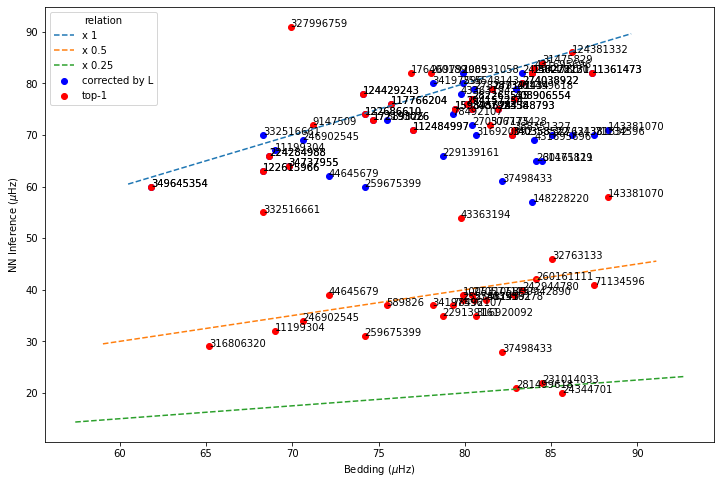

7.250201019495962


In [40]:
df_joined["corrected"] = corrected
df_joined["uncertainty"] = uncertainty

print(df_joined[["dnu", "corrected", "uncertainty"]])

fig, ax = plt.subplots()
ax.scatter(df_joined["dnu"], df_joined["corrected"], c="blue", label="corrected by L")
ax.scatter(df_joined["dnu"], df_joined["top-1"], c="red", label="top-1")
n = df_joined.index
for i, txt in enumerate(n):
    ax.annotate(txt, (df_joined.iloc[i][["dnu"]], df_joined.iloc[i][["corrected"]]))
    ax.annotate(txt, (df_joined.iloc[i][["dnu"]], df_joined.iloc[i][["top-1"]]))

abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
plt.legend(title="relation")
plt.xlabel("Bedding ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")
plt.show()

print(np.nanmean(np.sqrt(np.power(df_joined[["dnu"]].to_numpy() - df_joined[["corrected"]].to_numpy() ,2))))

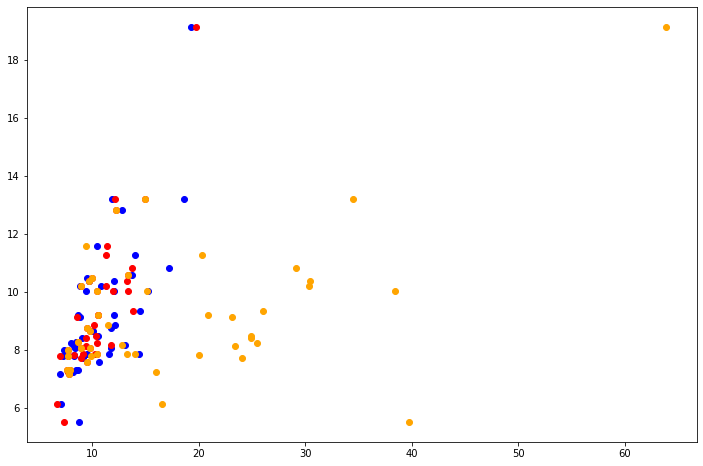

0.2101022371301483
0.5312782504815792
-0.41892338964015297


In [41]:
_x =  df_joined[df_joined['L'].notna()]

plt.scatter(gam_teff_dnu.predict(_x[["dnu", "Teff"]]), _x[["L"]].to_numpy().flatten(), c="blue")
plt.scatter(gam_teff_dnu.predict(_x[["corrected", "Teff"]]), _x[["L"]], c="red")
plt.scatter(gam_teff_dnu.predict(_x[["top-1", "Teff"]]), _x[["L"]], c="orange")


plt.show()

from sklearn.metrics import r2_score

print(r2_score(gam_teff_dnu.predict(_x[["dnu", "Teff"]]), _x[["L"]]))
print(r2_score(gam_teff_dnu.predict(_x[["corrected", "Teff"]]), _x[["L"]]))
print(r2_score(gam_teff_dnu.predict(_x[["top-1", "Teff"]]), _x[["L"]]))

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      2.4992
Link Function:                     IdentityLink Log Likelihood:                                  -202.7119
Number of Samples:                           46 AIC:                                              412.4221
                                                AICc:                                             413.1808
                                                GCV:                                               35.7137
                                                Scale:                                             32.2389
                                                Pseudo R-Squared:                                   0.1365
Feature Function                  Lam

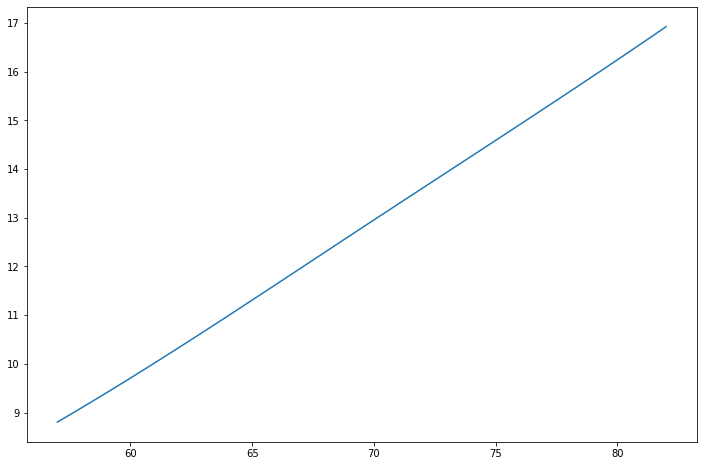

In [42]:
_x = df_joined[df_joined['L'].notna()]

gam2 = LinearGAM(s(0, n_splines=5))
gam2.fit(_x[["corrected"]], _x["dnu"])
gam2.summary()

XX = gam2.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam2.partial_dependence(term=0, X=XX))

print(r2_score(_x[["corrected"]], _x[["dnu"]]))

46


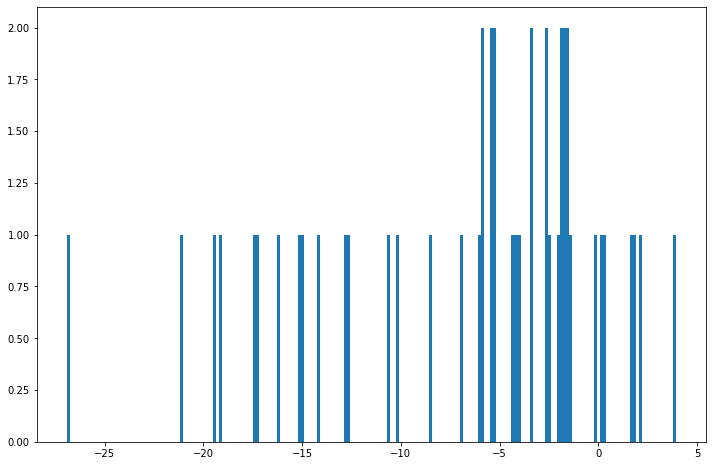

In [43]:
print(len(_x))
plt.hist(_x["corrected"] - _x["dnu"], bins=200)
plt.show()

In [44]:
import plotly.graph_objects as go

_x = df_dnu_l_teff_filter[df_dnu_l_teff_filter['l'].notna()].sample(1000)

print()
fig = go.Figure(data=[go.Surface(z=_x[["l"]].to_numpy().flatten(), x=_x[["dnu"]].to_numpy().flatten(), y=_x[["teff"]].to_numpy().flatten())])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

fig.update_layout(title='Dnu, Teff and L', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [45]:
"""
XX = gam_teff_dnu.generate_X_grid(term=0, meshgrid=True)
Z = gam_teff_dnu.partial_dependence(term=0, X=XX, meshgrid=True)


import plotly.graph_objects as go
z = Z
sh_0, sh_1 = z.shape
x=XX[0]
y=XX[1]
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

# Add BAD predictions
aux = df_joined[(df_joined.index=="11361473") | (df_joined.index=="143381070") | (df_joined.index=="32763133") | (df_joined.index=="32763133") | (df_joined.index=="148228220")| (df_joined.index=="34737955") | (df_joined.index=="122686610")][["Teff", "corrected", "L"]]

fig.add_scatter3d(x=aux[["corrected"]].to_numpy().flatten(), y=aux[["Teff"]].to_numpy().flatten(),z = aux[["L"]].to_numpy().flatten() + 25, mode='markers')

# Add good predictions
aux = df_joined[(df_joined.index=="100531058")]
fig.add_scatter3d(x=aux[["corrected"]].to_numpy().flatten(), y=aux[["Teff"]].to_numpy().flatten(),z = aux[["L"]].to_numpy().flatten() + 25, mode='markers')

fig.update_layout(title='Dnu, Teff and L', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()
"""

'\nXX = gam_teff_dnu.generate_X_grid(term=0, meshgrid=True)\nZ = gam_teff_dnu.partial_dependence(term=0, X=XX, meshgrid=True)\n\n\nimport plotly.graph_objects as go\nz = Z\nsh_0, sh_1 = z.shape\nx=XX[0]\ny=XX[1]\nfig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])\n\nfig.update_traces(contours_z=dict(show=True, usecolormap=True,\n                                  highlightcolor="limegreen", project_z=True))\n\n# Add BAD predictions\naux = df_joined[(df_joined.index=="11361473") | (df_joined.index=="143381070") | (df_joined.index=="32763133") | (df_joined.index=="32763133") | (df_joined.index=="148228220")| (df_joined.index=="34737955") | (df_joined.index=="122686610")][["Teff", "corrected", "L"]]\n\nfig.add_scatter3d(x=aux[["corrected"]].to_numpy().flatten(), y=aux[["Teff"]].to_numpy().flatten(),z = aux[["L"]].to_numpy().flatten() + 25, mode=\'markers\')\n\n# Add good predictions\naux = df_joined[(df_joined.index=="100531058")]\nfig.add_scatter3d(x=aux[["corrected"]].to_numpy().flatten()

In [46]:
df_joined

top-1        dnu      prob  top-k1  top-k2  top-k3  prob-topk1  \
TIC                                                                         
122686610     74  74.189813  0.526657      94      58      12    0.000601   
269792989     82  78.009257  0.233661      18      97      58    0.021134   
260161111     42  84.143518  0.139963      84      32      65    0.092620   
100531058     39  79.861112  0.499816      82      22      62    0.001430   
259675399     31  74.189813  0.126752      42      19      60    0.030677   
78492107      37  79.282406  0.371341      23      74      55    0.001911   
242944780     40  83.333331  0.260870      82      23      52    0.087674   
32763133      46  85.069443  0.115405      88      35      70    0.030893   
117766204     76  75.694444  0.346560      38      62      22    0.081482   
332516661     55  68.287038  0.235649      70      35      45    0.034795   
316806320     29  65.162038  0.270106      39      57      13    0.002457   
255548143     38  79.861112  0.146148      69      53      80    0.072075   
274038922     80  83.333331  0.315908      64      39      19    0.007572   
388351327     71  82.870369  0.248017      39      51      61    0.023921   
150272131     82  83.912037  0.470266      41      57      23    0.022094   
71134596      41  87.499999  0.485906      87      23      70    0.023552   
112484997     71  76.967594  0.238883      34      50      22    0.056450   
281499618     21  82.986112  0.304529      34      51      79    0.012736   
148228220     82  83.912037  0.154898      71      57      47    0.085190   
176400189     82  76.851850  0.126826      71      95      50    0.059650   
349645354     60  61.805557  0.159538      34      46      22    0.068536   
31475829      84  84.490743  0.488649      41      65      53    0.001071   
589826        37  75.462963  0.273800      23      73      12    0.013189   
34197596      37  78.125000  0.219918      80      62      22    0.023649   
122615966     63  68.287038  0.193372      31      44      73    0.058921   
287347434     79  81.597224  0.358862      39      62      52    0.000342   
37498433      28  82.175925  0.223746      40      16      61    0.097306   
294157254     76  80.092593  0.240811      38      53      66    0.019152   
327996759     91  69.907407  0.271181      44      72      56    0.049143   
459942890     39  82.870369  0.237194      80      55      23    0.084951   
340358522     70  82.754631  0.070641      38      57      84    0.069475   
124429243     78  74.074075  0.231704      38      55      22    0.033815   
44645679      39  72.106482  0.189241      62      22       4    0.002968   
278179191     38  80.555556  0.278376      79      50      27    0.020479   
172193026     73  74.652776  0.640161      35      63      53    0.002906   
348792358     75  80.439813  0.198064      63      34      96    0.109896   
431695696     83  84.027780  0.240737      41      69      57    0.235500   
9147509       72  71.180557  0.363941      35      12      88    0.022614   
282265535     77  80.439813  0.281301      39      52      62    0.001016   
124381332     86  86.226850  0.371598      42      70      57    0.007699   
463556278     38  81.250000  0.461308      80      23      55    0.002365   
316920092     35  80.671294  0.238940      70      47      57    0.010701   
408906554     77  82.870369  0.133039      38      49      22    0.128307   
43363194      54  79.745369  0.303580      35      78      66    0.056046   
284348793     75  81.944444  0.452991      60      37      90    0.000644   
143381070     58  88.310187  0.081303      88      45      71    0.063309   
11199304      32  68.981482  0.365773      67      55      43    0.089287   
224284988     66  68.634257  0.200500      32      51      20    0.099267   
229139161     35  78.703706  0.137835      46      20      66    0.012415   
246902545     34  70.601851  0.398031      22      69      46    0.007561   
2434470

### DS stars

In [47]:
from astronn.datasets import deltascuti
# Read datasets of preprocessed stars
df_ds = deltascuti()
dfds = df_ds.load("../../astronn/data/deltascuti/preprocessed/*", batch_size=1)

#### Process info from csv (L, Teff)

In [48]:
csv_ds = pd.read_csv("../data/deltascuti/binaries_obs.csv")
csv_ds

Unnamed: 0            ID  Dnu_muHz  eDnu_muHz  M_Msun  eM_Msun  Re_Rsun  \
0           1    KIC3858884        29          1    1.86    0.040    3.050   
1           2    KIC4544587        74          1    1.61    0.060    1.580   
2           3   KIC10661783        39          1    2.10    0.028    2.575   
3           4      HD172189        19          1    1.78    0.240    4.030   
4           5  CID100866999        56          1    1.80    0.200    1.900   
5           6  CID105906206        20          2    2.25    0.040    4.240   
6           7      HD159561        38          1    2.40    0.370    2.858   
7           8    KIC9851944        26          1    1.79    0.070    3.190   
8           9    KIC8262223        77          1    1.96    0.060    1.670   
9          10   KIC10080943        52          1    1.90    0.100    2.100   

   eRe_Rsun  Rp_Rsun  eRp_Rsun      M2     eM2     R2    eR2  rho_rhosun  \
0     0.010      NaN       NaN  1.8800  0.0300  3.450  0.010     0.06570   
1     0.030      NaN       NaN  1.9800  0.0700  1.820  0.030     0.41400   
2     0.015      NaN       NaN  0.1913  0.0025  1.124  0.019     0.12550   
3     0.110      NaN       NaN  1.7000  0.2200  2.370  0.070     0.02830   
4     0.200      NaN       NaN  1.1000  0.2000  0.900  0.200     0.26200   
5     0.020      NaN       NaN  1.2900  0.0300  1.340  0.010     0.02986   
6     0.015    2.388     0.013  0.8500  0.0600    NaN    NaN     0.12400   
7     0.040      NaN       NaN  1.7600  0.0700  2.270  0.030     0.05660   
8     0.040      NaN       NaN  0.2100  0.0100  1.320  0.030     0.42300   
9     0.200      NaN       NaN  2.0000  0.1000  2.900  0.100     0.20500   

   erho_rhosun  vsini_kms  evisini_kms  i_degree  ei_degree  omega_omegaK  \
0      0.00210       25.7          1.5    88.176      0.002        0.0754   
1      0.03900       75.8         15.0    87.900      3.000        0.1720   
2      0.00390       78.0          3.0    82.390      0.230        0.2000   
3      0.00610       78.0          3.0    73.200      0.600        0.2810   
4      0.11200        NaN          NaN    80.000      2.000           NaN   
5      0.00095       47.8          0.5    81.420      0.130        0.1520   
6      0.02100      239.0         12.0    87.500      0.600        0.8800   
7      0.00430       72.1          0.9    74.520      0.020           NaN   
8      0.04300       50.7          0.9    75.178      0.002           NaN   
9      0.07000       14.4          1.4    68.000      3.000           NaN   

   L.Ltot  Teff  eTeff   logg  elogg   Teff2  eTeff2  logg2  elogg2  logg_sp  \
0   0.470  6606   70.0  3.740  0.010  6800.0    70.0  3.630   0.010     3.98   
1   0.332  7750  180.0  4.330  0.010  8600.0   100.0  4.241   0.009     3.84   
2   0.937  7764   54.0  3.938  0.004  5980.0    72.0  3.618   0.015     3.90   
3   0.702  7750    NaN  3.480  0.080  8250.0     NaN  3.920   0.080     4.00   
4     NaN  7300  250.0  4.100  0.100  5400.0   430.0  5.400   0.300     4.00   
5   0.940  6750  150.0  3.530  0.010  6152.0   162.0  4.300   0.010     3.90   
6   1.000  8047  154.0  3.890  0.200     NaN     NaN    NaN     NaN     4.00   
7   0.500  6902  100.0  3.690  0.030  7026.0   100.0  3.960   0.030     4.04   
8   0.900  9128  130.0  4.280  0.020  6885.0    24.0  3.520   0.020     3.90   
9   0.500  7480  200.0  4.100  0.100  7100.0   200.0  3.810   0.030     4.05   

   elogg_sp  parallax  eparallax       mv     emv       mb     emb    B.V  \
0      0.15      1.78       0.22   9.3360  0.0180   9.8050  0.0220    NaN   
1      0.13      1.36       0.41  10.8470  0.0540  10.9900  0.0430    NaN   
2      0.12      1.94       0.26   9.5630  0.0210   9.8440  0.0220    NaN   
3       NaN      2.27       0.34   8.8850  0.0320   9.2410  0.0290    NaN   
4      0.38       NaN        NaN  15.0970  0.0250  16.0360  0.0250    NaN   
5      0.38      0.96       0.25  12.2620  0.2200  12.7780  0.2570    NaN   
6      0.50     67.13       1.06   2.12

In [49]:
# read data
csv_ds = pd.read_csv("../data/deltascuti/binaries_obs.csv")

# 1 mas = 0.00099999995874704 arcsec
Mv = csv_ds["mv"] + 5 * (np.log10(csv_ds["parallax"] * 0.00099999995874704) + 1)
mbolsun = 4.74
# calculate Luminosity
csv_ds["L"] = (np.power(10, 0.4 * (mbolsun - Mv))) * csv_ds["L.Ltot"]

csv_ds[["ID", "Dnu_muHz", "L", "Teff"]].head(11)
#for index, row in csv_ds[["ID", "Dnu_muHz", "L", "Teff"]].iterrows():
#    print("" % row["ID"], gam_teff_dnu.predict(np.asarray([35, 7750]).reshape(1,2))

ID  Dnu_muHz          L  Teff
0    KIC3858884        29  21.520774  6606
1    KIC4544587        74   6.475306  7750
2   KIC10661783        39  29.304625  7764
3      HD172189        19  29.942319  7750
4  CID100866999        56        NaN  7300
5  CID105906206        20   9.995060  6750
6      HD159561        38  24.642612  8047
7    KIC9851944        26  60.062351  6902
8    KIC8262223        77   1.333914  9128
9   KIC10080943        52   7.085301  7480

Processing star id kic10661783
29.304624905885404
[402.59, 62.64, 424.14, 771.47]
[81, 38, 71, 19]
39 : 38
Processing star id CID105906206
9.995060410479088
[204.06, 9.27, 2.91, 2499.49]
[22, 34, 51, 10]
20 : 51
Processing star id kic4544587
6.475306094529597
[298.07, 2506.47, 2.71, 37.88]
[35, 19, 76, 54]
74 : 76
Processing star id HD172189
29.942319043512317
[88.13, 91.44, 250.35, 4065.04]
[23, 39, 50, 12]
19 : 23
Processing star id HD15082
*
Processing star id KIC8262223
1.3339142966183681
[9780.44, 3730.29, 1328.32, 420.91]
[22, 32, 43, 61]
77 : 61
Processing star id KIC3858884
21.520774117208067
[0.02, 207.96, 121.9, 311.9]
[23, 54, 38, 85]
29 : 23
Processing star id HD159561
24.642612134730655
[4.15, 804.14, 62.61, 226.58]
[37, 22, 50, 76]
38 : 37
Processing star id KIC10080943
7.0853010787549975
[268.46, 14.78, 0.82, 4658.7]
[29, 54, 67, 13]
52 : 67
Processing star id CID100866999
nan
[nan, nan, nan, nan]
[51, 21, 61, 88]
56 : 51
Processing star id KIC9851944
60.062350874539206


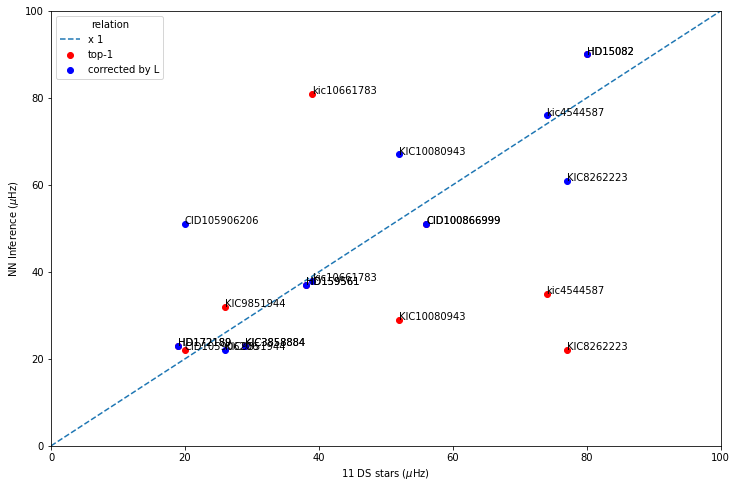

8.636363636363637
17.545454545454547


In [50]:
corrected = []
ids = []
dnus = []
tops1 = []
for star in dfds.take(11):
    # Get L from 
    print("Processing star id %s" % star[0].numpy()[0].decode("utf-8"))
    if star[0].numpy()[0].decode("utf-8").lower() in csv_ds["ID"].str.lower().values:
        l = csv_ds[csv_ds["ID"].str.lower() == star[0].numpy()[0].decode("utf-8").lower()]["L"].to_numpy()[0]
        Teff = csv_ds[csv_ds["ID"].str.lower() == star[0].numpy()[0].decode("utf-8").lower()]["Teff"].to_numpy()[0]
        print(l)
        # Get probs
        probs = sepconv_mod.predict_proba(star[1])[0]
        # Find peaks
        peaks, _ = find_peaks(probs, height=0, distance=10)
        peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
        # we skip the 0 beacuse is the first one
        top1 = np.where(probs==peaks_sorted_by_prob[0])[0][0]
        topk1 = np.where(probs==peaks_sorted_by_prob[1])[0][0]
        topk2 = np.where(probs==peaks_sorted_by_prob[2])[0][0]
        topk3 = np.where(probs==peaks_sorted_by_prob[3])[0][0]
        tops = [top1, topk1, topk2, topk3]

        # Get probs
        probtop1 =  probs[np.where(probs==peaks_sorted_by_prob[0])[0][0]]
        probtopk1 =  probs[np.where(probs==peaks_sorted_by_prob[1])[0][0]]
        probtopk2 =  probs[np.where(probs==peaks_sorted_by_prob[2])[0][0]]
        probtopk3 =  probs[np.where(probs==peaks_sorted_by_prob[3])[0][0]]
        # Get L from top-k
        l_top1 = round(gam_teff_dnu.predict(np.asarray([top1, Teff]).reshape(1,2))[0], 2)
        l_topk1 = round(gam_teff_dnu.predict(np.asarray([topk1, Teff]).reshape(1,2))[0], 2)
        l_topk2 = round(gam_teff_dnu.predict(np.asarray([topk2, Teff]).reshape(1,2))[0], 2)
        l_topk3 = round(gam_teff_dnu.predict(np.asarray([topk3, Teff]).reshape(1,2))[0], 2)

        # Get L errors
        errors = [
                round(np.power(l_top1 - l, 2), 2),
                round(np.power(l_topk1 - l, 2), 2),
                round(np.power(l_topk2 - l, 2), 2),
                round(np.power(l_topk3 - l, 2), 2),
            ]
            #uncertainty.append(np.sum([in_conf_top1,in_conf_topk1,in_conf_topk2,in_conf_topk3]))
        i = np.argmin(errors)
        print(errors)
        print(tops)
        print("%s : %s" % (np.where(star[2].numpy().flat == 1)[0].flat[0], tops[i]))

        ids.append(star[0].numpy()[0].decode("utf-8"))
        dnus.append(np.where(star[2].numpy().flat == 1)[0].flat[0])
        corrected.append(tops[i])
        tops1.append(top1)
    else:
        print("*")
        probs = sepconv_mod.predict_proba(star[1])[0]
        peaks, _ = find_peaks(probs, height=0, distance=10)
        peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
        corrected.append(np.where(probs==peaks_sorted_by_prob[0])[0][0])
        tops1.append(np.where(probs==peaks_sorted_by_prob[0])[0][0])
        ids.append(star[0].numpy()[0].decode("utf-8"))
        dnus.append(np.where(star[2].numpy().flat == 1)[0].flat[0])

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', label="x "+str(slope))
    

fig, ax = plt.subplots()
plt.xlim(0, 100)
plt.ylim(0, 100)
ax.scatter(dnus, tops1, c="red", label="top-1")
ax.scatter(dnus, corrected, c="blue", label="corrected by L")
n = df_joined.index
for i, txt in enumerate(ids):
    ax.annotate(txt, (dnus[i], corrected[i]), size=10)
    ax.annotate(txt, (dnus[i], tops1[i]), size=10)

abline(1, 0)
plt.legend(title="relation")
plt.xlabel("11 DS stars ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")
plt.show()


print(np.nanmean(np.sqrt(np.power(np.asarray(dnus) - np.asarray(corrected) ,2))))
print(np.nanmean(np.sqrt(np.power(np.asarray(dnus) - np.asarray(tops1) ,2))))

### CoRoT study

In [51]:
vrrhosun = 1.409
vrloggsun = 4.44

def getRhoFromDnu(Dnu, e_Dnu=0):
    """
    calculate Rho from Dnu estimating the error produced
    """
    rho_sun = 1.409
    dnu_sun = 134.8
    a = 1.501
    e_a = 0.096
    b = 2.0373
    e_b = 0.0405
    rho = (a * (Dnu / dnu_sun) ** b) * rho_sun
    e_rho = rho * np.sqrt(
        (e_a / a) ** 2
        + (b * e_Dnu / (Dnu * dnu_sun)) ** 2
        + (np.log10(Dnu / dnu_sun) * e_b) ** 2
    )
    return {"rho": rho, "error": e_rho}


def get_radio_from_rho(rho, e_rho):
    """
    calculate radio from rho, estimating max and min values
    """
    R_min = (1.5 / (rho + e_rho) / vrrhosun) ** (1 / 3)
    R_max = (3 / (rho - e_rho) / vrrhosun) ** (1 / 3)
    return {"r_min": R_min, "r_max": R_max}


def get_logg_from_radio(R_max, R_min):
    """
    calculate logg from radio estimating max and min values
    """
    logg_min = np.log10(1.5 / R_max ** 2) + vrloggsun
    logg_max = np.log10(3 / R_min ** 2) + vrloggsun
    return {"logg_min": logg_min, "logg_max": logg_max}

def get_logg_confidence(dnu_hat):
    """
    """
    rhos = getRhoFromDnu(dnu_hat, 4)
    radios = get_radio_from_rho(rhos["rho"], rhos["error"])
    loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
    # Get central point of logg confidence
    loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
    return loggs_condifence

In [52]:
# read data
csv_corot = pd.read_csv("/home/roberto/Projects/asteroseismologyNN/Paparo-Gaia-Bai.csv")
csv_corot

Seq_1    CoRoT_1  Teff_1   logg  teff_val  lum_val
0       1  102661211    7075  3.575   5847.00   10.629
1       2  102671284    8550  3.650   7542.00   22.747
2       3  102702314    7000  2.975   5528.01   16.841
3       4  102712421    7400  3.950   7364.00    5.280
4       6  102703251    9100  3.800   7853.50   20.071
..    ...        ...     ...    ...       ...      ...
64     90  102691322    7650  4.050   6345.00      NaN
65     91  102691789    7800  3.750   6947.67   10.103
66     93  102794872    7575  4.150   7575.81    7.369
67     94  102596121    7700  4.000   6412.00    5.060
68     95  102598868    7750  3.900   7172.00    8.104

[69 rows x 6 columns]

In [53]:
with open("../models/gam_teff_dnu/gam.pkl", 'rb') as f:
    gam_teff_dnu = pickle.load(f)

In [54]:
# Read datasets of preprocessed stars
df_cor = corot()
dfcor = df_cor.load("../../astronn/data/corot/preprocessed/*.log", batch_size=1)

count = 0
# DS to save logg_g compatibles
_logg_data = []
_logg_dnu = []
_star_id = []
_aux =  []
for star in dfcor.take(75):  # take the 75 corot stars
    corotid = int(star[0].numpy()[0].decode("utf-8"))
    print(corotid)

    if len(csv_corot[csv_corot["CoRoT_1"] == corotid]) > 0:
        lum = float(csv_corot[csv_corot["CoRoT_1"] == corotid]["lum_val"])
        Teff = float(csv_corot[csv_corot["CoRoT_1"] == corotid]["Teff_1"])

        print("(Lum:%s Teff:%s)"% (lum, Teff))

        x_star = star[1].numpy()
        # Star logg from data
        logg_data = star[2][0].numpy()
        _logg_data.append(logg_data)
        _star_id.append(star[0].numpy()[0].decode("utf-8"))

        # Get probs
        probs = sepconv_mod.predict_proba(star[1])[0]
        # Find peaks
        peaks, _ = find_peaks(probs, height=0, distance=10)
        peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
        # we skip the 0 beacuse is the first one
        top1 = np.where(probs==peaks_sorted_by_prob[0])[0][0]
        topk1 = np.where(probs==peaks_sorted_by_prob[1])[0][0]
        topk2 = np.where(probs==peaks_sorted_by_prob[2])[0][0]
        topk3 = np.where(probs==peaks_sorted_by_prob[3])[0][0]
        tops = [top1, topk1, topk2, topk3]

        # Get probs
        probtop1 =  probs[np.where(probs==peaks_sorted_by_prob[0])[0][0]]
        probtopk1 =  probs[np.where(probs==peaks_sorted_by_prob[1])[0][0]]
        probtopk2 =  probs[np.where(probs==peaks_sorted_by_prob[2])[0][0]]
        probtopk3 =  probs[np.where(probs==peaks_sorted_by_prob[3])[0][0]]
        # Get L from top-k
        l_top1 = round(gam_teff_dnu.predict(np.asarray([top1, Teff]).reshape(1,2))[0], 2)
        l_topk1 = round(gam_teff_dnu.predict(np.asarray([topk1, Teff]).reshape(1,2))[0], 2)
        l_topk2 = round(gam_teff_dnu.predict(np.asarray([topk2, Teff]).reshape(1,2))[0], 2)
        l_topk3 = round(gam_teff_dnu.predict(np.asarray([topk3, Teff]).reshape(1,2))[0], 2)

        
        # Get L errors
        errors = [
                round(np.power(l_top1 - lum, 2), 2),
                round(np.power(l_topk1 - lum, 2), 2),
                round(np.power(l_topk2 - lum, 2), 2),
                round(np.power(l_topk3 - lum, 2), 2),
            ]
            #uncertainty.append(np.sum([in_conf_top1,in_conf_topk1,in_conf_topk2,in_conf_topk3]))

        print(lum)
        print(errors)
        print(tops)

        i = np.argmin(errors)
        print(i)
        # Calculate logg from Dnu infered by the NN
        rhos = getRhoFromDnu(tops[i], 4)
        radios = get_radio_from_rho(rhos["rho"], rhos["error"])
        loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
        # Get central point of logg confidence
        loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2

        flag = (
            logg_data <= loggs_condifence["logg_max"]
            and logg_data >= loggs_condifence["logg_min"]
        )
        _aux.append(flag) # save

        _logg_dnu.append(loggs_average)

102688156
(Lum:8.445 Teff:7725.0)
8.445
[4.91, 78.77, 0.01, 2.58]
[96, 43, 72, 83]
2
102712421
(Lum:5.28 Teff:7400.0)
5.28
[409.66, 137.12, 2824.92, 24.3]
[26, 38, 16, 55]
3
102691322
(Lum:nan Teff:7650.0)
nan
[nan, nan, nan, nan]
[38, 81, 18, 55]
0
102710813
(Lum:6.3389999999999995 Teff:8350.0)
6.3389999999999995
[239.35, 1542.21, 98.62, 24.71]
[47, 27, 57, 76]
3
102745499
(Lum:15.005 Teff:7900.0)
15.005
[332.15, 68.97, 5747.91, 19012.27]
[27, 38, 14, 3]
1
102656251
102687709
(Lum:5.882000000000001 Teff:7950.0)
5.882000000000001
[12.24, 294.4, 108.33, 27.12]
[79, 39, 49, 64]
0
102787451
(Lum:6.22 Teff:7300.0)
6.22
[0.01, 12.25, 94.67, 1.88]
[76, 55, 38, 65]
0
102650434
(Lum:13.187999999999999 Teff:8500.0)
13.187999999999999
[3427.17, 879.24, 189.67, 14733.59]
[22, 32, 43, 12]
2
102673795
(Lum:23.997 Teff:8050.0)
23.997
[117.44, 38.53, 104.59, 155.68]
[97, 48, 86, 65]
1
102702932
(Lum:25.443 Teff:6975.0)
25.443
[13.97, 162.64, 276.99, 4020.45]
[21, 39, 53, 4]
0
102786753
(Lum:9.439 Tef

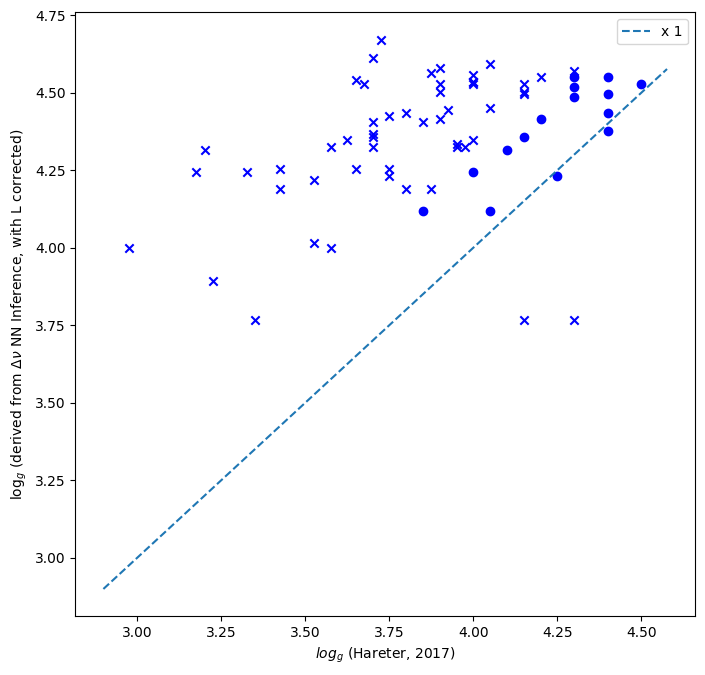

In [55]:
fig = plt.subplots(1, figsize=(8, 8), dpi=100)
aux=[]
for i in range(len(_aux)):
    if _aux[i]:
        mark = "o"  # compatible
    else:
        mark = "x"  # no-compatible
    plt.scatter(_logg_data[i], _logg_dnu[i],  marker=mark, color="blue")

#plt.scatter(_logg_data, _logg_dnu)
abline(1, 0)
plt.legend(title="")
plt.xlabel("$log_g$ (Hareter, 2017)")
plt.ylabel("$\log_g$ (derived from $\Delta\\nu$ NN Inference, with L corrected)")
plt.show()

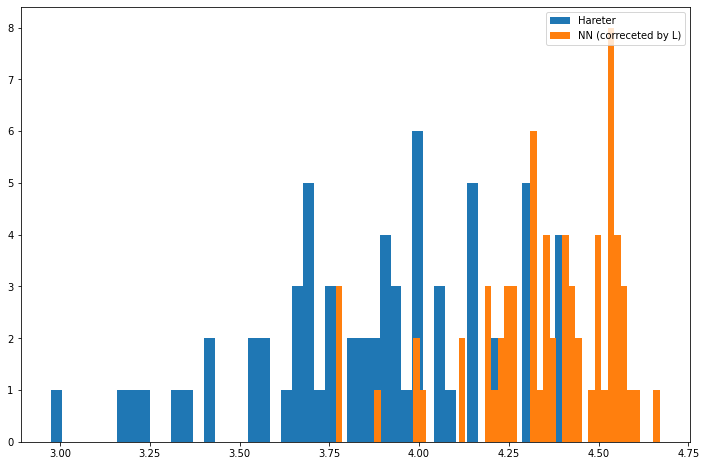

In [56]:
plt.hist(_logg_data, label="Hareter", bins=50)
plt.hist(_logg_dnu, label="NN (correceted by L)", bins=50)
plt.legend(loc='upper right')
plt.show()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      2.5028
Link Function:                     IdentityLink Log Likelihood:                                  -737.6264
Number of Samples:                           67 AIC:                                             1482.2584
                                                AICc:                                            1482.7631
                                                GCV:                                                0.0384
                                                Scale:                                              0.0359
                                                Pseudo R-Squared:                                   0.1948
Feature Function                  Lam

[<matplotlib.lines.Line2D at 0x7f3ef9035710>]

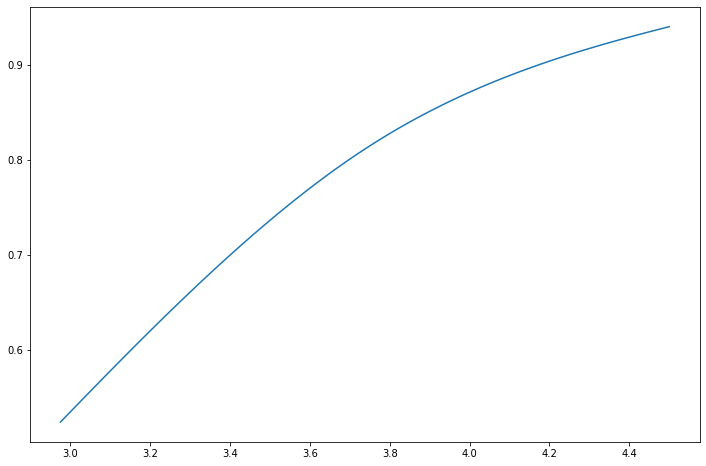

In [57]:
from pygam import LogisticGAM, LinearGAM, s, te
g = LinearGAM(s(0, n_splines=5))
g.fit(_logg_data, _logg_dnu)
g.summary()


XX = g.generate_X_grid(term=0)
plt.plot(XX[:, 0], g.partial_dependence(term=0, X=XX))